In [0]:
# libraries/tools/api to collect data
# praw
# pushshift.io
# google scripts

# which feature to collect and why
----------
# how to collect data from reddit
# which flairs/topics to consider
# which features to extract
# although we will collect all features and do eda to find out which
# ones are important and which ones are not
# try pushshift
# use pushshift api at the time of web app
# try multiprocessing
# discuss our approach
# which dataset to use?
# you own?
# features?
# 

In [0]:
# authenticate using credientials
reddit = praw.Reddit(client_id = "nBaGWBrD5t5GpQ",
                     client_secret = "7lu-TR0podC8dxaOeRb0nU36iK0",
                     user_agent = "Reddit Flare Detection",
                     username = "gauravchopracg",
                     password = "07aug1998")

Reddit Data Collection:
===
This part has been divided to answer question like:
* How to collect data from reddit
* Which features to extract from subreddit post (which will shape our future decision of building a Reddit Flair Detector)
* What we should consider while choosing a particular API to scrape reddit

How to Scrape Reddit:
===

In this section, we will try to answer basic question like:
* how to collect data from any subreddit?
* which tools to use and their limitations?

that being said let's get to work.

**There are number of tools and libraries available to scrape reddit:**

In this part, I have only consider three types of them for a beginner to advance programmers


##1. PRAW API:-
PRAW, an acronym for "Python Reddit API Wrapper", is a python package that allows for simple access to reddit's API. An API is a gateway through which user can access and modify data of any website.
PRAW has some great features which makes it easy-to-use for beginners like:
  * simpler interface
  * little to no skill required to use

However, it has some limitations like:-
  * you can fetch only upto 1000 submission or posts from reddit
  * PRAW has a [lazy object](https://praw.readthedocs.org/en/stable/pages/lazy-loading.html) model, so it won't make any more requests than it needs to which means that in fetching comments, it makes a new request for each username that going to take hours to collect.

Other than that, it requires user to create an account in reddit, sign up as developer, create an application and then provide credentials for obtaining data.

Enough taking let's get starting on how to use it

### How to use:
The very first thing you'll need to do is "Create an App" within Reddit to get the OAuth2 keys to access the API. 

Go to [this page](https://www.reddit.com/prefs/apps) and click create app or create another app button at the bottom left

<img src="https://miro.medium.com/max/1400/1*GQ8IREDENnkCRQT3VS55mQ.png">

This will open a form where you need to fill in a name, description and redirect uri. For the redirect uri you should choose https://localhost:8080 as described in the excellent [PRAW documentation](https://praw.readthedocs.io/en/latest/getting_started/authentication.html#script-application).

<img src="https://miro.medium.com/max/1400/1*ssLYczSLGzfm6SPM7mWzBg.png">

After pressing create app a new application will appear. Here you can find the authentication informtion needed to create the prew.Reddit instance.

<img src="https://miro.medium.com/max/1400/1*khszOCCaCtqZ6jM19uhpiQ.png">

Now, you can use this information to authenticate yourself.

In [0]:
# PRAW can be installed using python package installer
!pip install praw

In [0]:
# import library
import praw

# Before it can be used to scrape data we need to authenticate ourselves.
# Use the information from the above section to know how to do it.
# For this we need to create a Reddit instance and provide it with client_id,
# client_secret, user_agent, username and password
reddit = praw.Reddit(client_id='PERSONAL_USE_SCRIPT_14_CHARS', \
                     client_secret='SECRET_KEY_27_CHARS ', \
                     user_agent='YOUR_APP_NAME', \
                     username='YOUR_REDDIT_USER_NAME', \
                     password='YOUR_REDDIT_LOGIN_PASSWORD')

# get post from india subreddit
india_subreddit = reddit.subreddit('india')

If you visit any post in [r/india](https://www.reddit.com/r/india/) subreddit, the topics in r/india subreddit are: **AskIndia, Non-Political, Scheduled, Photography, Science/Technology, Politics, Business/Finance, Policy/Economy,Sports, Food, Coronavirus**. So, these are only ones which are used to collect features of particular posts (as of writing this notebook 20/4/2020). You can observe that there are 24 attributes of a subreddit post as discussed in [PRAW documentation](https://praw.readthedocs.io/en/latest/code_overview/models/submission.html).For Reddit flair detection task, I have only considered ones that are related to flair of the post.

**Note: This is the hypothesis of data collection that we will try to verify in EDA section**

These are given in following table: 

| Attribute | Description |
| --- | --- |
| author | Author of that post (Some people only post political content, some post Science/Technology content). |
| comments | Comments on that particular post relates to Language Modelling.  |
| created_utc | Time the submission was created, represented in Unix Time. (This might relate to people post religious content in morning and political in afternoon) |
| id | ID of the submission. |
| is_self | Whether or not  the submission is a selfpost (text-only). |
| link_flair_text | The flair of that particular postThe link flair's text content, or None if not flaired. |
| name | Fullname of the submission |
| num_comments | The number of comments on that post. |
| over_18 | Whether or not the submission has been marked as NSFW. |
| score | The number of upvotes for the submission. |
| selftext | The submission selftext - an empty string if a link post. |
| title | The title of the submission. |
| upvote_ratio | The percentage of upvotes from all votes on the submission. |
| url | The URL the submission links to, or the permalink if a selfpost. |

In [0]:
# only for testing:
# import library
import praw

# Before it can be used to scrape data we need to authenticate ourselves.
# Use the information from the above section to know how to do it.
# For this we need to create a Reddit instance and provide it with client_id,
# client_secret, user_agent, username and password
reddit = praw.Reddit(client_id='QPdCUgBcp4WinA', client_secret='HF-sKHVC5Os3gufVxWvzIKijNb4', user_agent='reddit-flair', username='reddit-flair', password='flair123')

# get post from india subreddit
subreddit = reddit.subreddit('india')

In [0]:
%%time
# to calculate time taken to scrape reddit

# create an empty python list to append posts from subreddit
posts = []

# a python list of all the flairs to collect post from corresponding tags
# These will be the labels in classification.
flairs = ["AskIndia", "Non-Political", 
          "Scheduled", "Photography", "Science/Technology",
          "Politics", "Business/Finance", "Policy/Economy",
          "Sports", "Food", "Coronavirus"]

# iterate through each flair
for flair in flairs:
  
  # collect relevant posts by searching in subreddit (less than 100)
  relevant_subreddits = subreddit.search(f"flair_name:{flair}", limit=100)
  
  # iterate through each post
  for submission in relevant_subreddits:
    submission.comments.replace_more(limit=None)
    comment=''
    authors=''
    count=0
    for top_level_comment in submission.comments:
      # join all comments on post
      comment = comment + ' ' + top_level_comment.body
      # join all authors of comments on post
      authors = authors + ' ' + str(top_level_comment.author)

      count+= 1
        if (count>10):
        break

    posts.append([submission.author, submission.created_utc, submission.link_flair_text, submission.num_comments, submission.score, submission.over_18, submission.selftext, submission.title, submission.url, submission.id, submission.over_18, submission.upvote_ratio, submission.name, submission.ups, submission.downs, submission.is_self, comment, authors])

In [0]:
import pandas as pd # for data preprocessing and manipulation

# transform list of dictionary to pandas dataframe for easier preprocessing
data = pd.DataFrame(posts, columns = ['author', 'created_utc', 'link_flair_text', 'num_comments', 'score', 'over_18', 'selftext', 'title', 'url', 'id', 'over_18', 'upvote_ratio', 'name', 'ups', 'downs', 'is_self', 'comment', 'authors'])

In [0]:
# a look at data
data.head()

In [0]:
# for further preprocessing, transform it into csv file as it saves time 
# and we don't have to go through same process again.
data.to_csv('data.csv', index=None)

In [0]:
# only works on Google Colab
from google.colab import files
# download data on personal computer
files.download('data.csv')

### Might want to consider:
If you are planning on using PRAW API for Reddit Data Collection, it has a limitation of sending new request for fetching comments. In the above block, It took **7 hours to collect 1000 post from 10 flairs (with 10 comments from each post)**. One way to overcome this problem is to use multiprocessing

In [0]:
# using multiprocessing:

##2. Pushshift's API :- 
PRAW is the main Reddit API used for extracting data from the site using Python. Although there are a few limitations including extracting submissions between specific dates and you can only extract 1000 submission from a subreddit. This inconvenience was overcome by Pushshift's API for accessing Reddit's data.


**The Pushshift API**

Pushshift is a big-data storage and analytics project started and maintained by Jason Baumgartner. The Pushshift API serves a copy of reddit objects. Currently, data is copied into Pushshift at the time it is posted to reddit. Therefore, scores and other meta such as edits to a submission's selftext or a comment's body field may not reflect what is displayed by reddit. A future version of the API will update data at timed intervals.

But it has some great features like:
  * access the subreddit Data without even needing Reddit credentials.
  * analyze large quantities of reddit data
  * grab data for a specific data range in the past
  * search for comments
  * aggregate data

### How to use
We can access the Pushshift API through building an URL with the relevant parameters without even needing Reddit credentials.

Without parameters, this is the foundation of the URL you'll use to access Redit: https://api.pushshift.io/reddit/search/

Now with parameters, This is the url which will access india subreddit between 2 dates written in unix timestamps and search for all submission that contain the keyword - **coronavirus**: https://api.pushshift.io/reddit/search/submission/?q=coronavirus&after=1514764800&before=1517443200&subreddit=india

So, this will be the template in which we can insert dates and keyword to search for specific posts: https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)

**To make sure we are getting everything for the specific time period**

we can crate a method for building time period search intervals. Add in logic to request more posts. We will pull the last created on timestamp prior to the next request.

**NOTE: This method has a downside that it can fetch duplicates**

In [0]:
# Import the relevant modules
import pandas as pd # for reading csv file and data manipulation
import requests # to access the Pushshift API through building an URL
import json # to transform web page data into json format
import csv # to upload into a CSV for further analysis
import time # for transformation of timestamps
import datetime # for transformation of timestamps

In [0]:
# Subreddit to query
sub = 'india'
# before and after dates
before = "1538352000" # October 1st
after = "1524764800" # January 1st
query = "state" # to search in subreddit
subCount = 0
subStats = {}

In [0]:
# We can access the Pushshift API through building an URL with the relevant
# parameters without even needing Reddit credentials
url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
# to know how does the data look like click below pushshift URL with
# the parameters to see for yourself
url

In [0]:
r = requests.get(url) # Requests module is used to access the URL  
data = json.loads(r.text) # with the JSON module collecting the text version of the page
dat = data['data']
dat[0] # a look at first post

In [0]:
def getPushshiftData(query, after, before, sub):
    '''
    Function to transform web page data into json
    '''
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url) # Requests module is used to access the URL
    data = json.loads(r.text) # with the JSON module collecting the text version of the page
    return data['data']

In [0]:
# similarly we can build another function to extract key data points:
def collectSubData(subm):
    subData = list() #list to store data points
    title = subm['title'] # title of the subreddit post
    url = subm['url'] # url associated with it
    try:
        flair = subm['link_flair_text'] # flair if given which it belongs to
    except KeyError:
        flair = "NaN"  # else none
    author = subm['author'] # author of post
    sub_id = subm['id'] # unique identifier of post
    score = subm['score'] # number of upvotes
    created = datetime.datetime.fromtimestamp(subm['created_utc']) #1520561700.0
    numComms = subm['num_comments'] # number of comments
    permalink = subm['permalink'] # permalink of post
    
    subData.append((sub_id,title,url,author,score,created,numComms,permalink,flair)) # adding it a single python list
    subStats[sub_id] = subData

In [0]:
# now we can run code and loop until all submission are collected from 
# a subreddit
data = getPushshiftData(query, after, before, sub)
# Will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    data = getPushshiftData(query, after, before, sub)
    
print(len(data))

In [0]:
# sanity check to make sure we have our data for futher analysis
print(str(len(subStats)) + " submissions have added to list")
print("1st entry is:")
print(list(subStats.values())[0][0][1] + " created: " + str(list(subStats.values())[0][0][5]))
print("Last entry is:")
print(list(subStats.values())[-1][0][1] + " created: " + str(list(subStats.values())[-1][0][5]))

In [0]:
# upload to csv file
def updateSubs_file():
    '''
    function to store data into a csv file
    '''
    upload_count = 0
    # directory of google colaboratory
    location = "\content\" 
    print("input filename of submission file, please add .csv")
    filename = input()
    file = location + filename
    with open(file, 'w', newline='', encoding='utf-8') as file: 
        a = csv.writer(file, delimiter=',')
        headers = ["Post ID","Title","Url","Author","Score","Publish Date","Total No. of Comments","Permalink","Flair"]
        a.writerow(headers)
        for sub in subStats:
            a.writerow(subStats[sub][0])
            upload_count+=1
            
        print(str(upload_count) + " submissions have been uploaded") # print updates while writing into csv file
updateSubs_file()

##3. There is also third method:-

Using BeautifulSoup4 and request library
---
In this method, we'll using requests to get web pages and using BeautifulSoup4 package to extract information from raw HTML.


In [0]:
# we will be using requests and beautifulsoup4 library
# install them using python package installer
!pip install requests beautifulsoup4

In [0]:
# importing libraries
import requests # getting web pages
import csv # for write our results into CSV file
import time # to calculate how much time it takes to run program
from bs4 import BeautifulSoup # for extracting information from raw HTML

In [0]:
url = "https://old.reddit.com/r/datascience/"
# Headers to mimic a browser visit
headers = {'User-Agent': 'Mozilla/5.0'}

# Returns a requests.models.Response object
page = requests.get(url, headers=headers)

In [0]:
soup = BeautifulSoup(page.text, 'html.parser')

In [0]:
domains = soup.find_all("span", class_="domain")

In [0]:
soup.find_all("span", {"class": "domain", "height", "100px"})

In [0]:
for domain in domains:
  if domain != "(self.datascience)":
    continue
  
  print(domain.text)

In [0]:
for domain in soup.find_all("span", class_="domain"):
  if domain != "(self.datascience)":
    continue
  

  parent_div = domain.parent.parent.parent.parent
  print(parent_div.text)

In [0]:
attrs = {'class': 'thing', 'data-domain': 'self.datascience'}

for post in soup.find_all('div', attrs=attrs):
  print(post.attrs['data-domain'])

In [0]:
title = post.find('p', class_="title").text

In [0]:
author = post.find('a', class_='author').text

In [0]:
comments = post.find('a', class_='comments').text

In [0]:
comments = post.find('a', class_='comments').text.split()[0]

In [0]:
if comments == "comment":
  comments = 0

In [0]:
likes = post.find("div", attrs={"class": "score likes"}).text

In [0]:
if likes == "•":
    likes = "None"

In [0]:
counter = 1
for post in posts:
  ...
  post_line = [counter, title, author, likes, comments]
  with open('output.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(post_line)

  counter += 1

In [0]:
counter = 1

while (counter <= 100):
  for post in posts:
    # Getting the title, author, ....
    # Writing to CSV and incrementing counter...

  next_button = soup.find("span", class_="next-button")
  next_page_link = next_button.find("a").attrs['href']
  time.sleep(2)
  page = requests.get(next_page_link, headers=headers)
  soup = BeautifulSoup(page.tex, 'html.parser')

Approach:
---
In this part, I have only different considered ways to scrape Reddit with their own limitations. The aim of this Part is explore different libraries to collect data, recognizing their limitations and choosing one suitable for our task i.e., Reddit Flair Detection.

As, our task requires us to building a Reddit Flair Detection classifier and deploying it to heroku. Since, we are going to test different machine learning models and deep learning algorithms it will be beneficial if we have millions of observations on dataset, so dataset size should be big. Therefore, I have used PushShift API to collect reddit data from **March 1st 2020 to April 15 2020**

In [0]:
import pandas as pd
import requests
import json
import csv
import time
import datetime

def getPushshiftData(after, before):
    sub = "india"
    url = 'https://api.pushshift.io/reddit/search/submission/?size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

def collectSubData(subm):
    subData = list() #list to store data points
    sub_id = subm['id']
    title = subm['title']  
    
    try:
        body = subm['selftext']
    except KeyError:
        body = "" 
    
    try:
        flair = subm['link_flair_text']
        subData.append((title,body,flair))
        subStats[sub_id] = subData
    except KeyError:
        flair = "NaN" 

        
#before and after dates
before = "1577836800" #01/01/2020 @ 12:00am (UTC)
after = "1546300800"  #01/01/2019 @ 12:00am (UTC)
subCount = 0
subStats = {}

In [0]:
data = getPushshiftData(after, before)

# Will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    data = getPushshiftData(after, before)
    
print(len(data))

subStats = list(subStats.values())

https://api.pushshift.io/reddit/search/submission/?size=1000&after=1546300800&before=1577836800&subreddit=india
1000
2019-01-03 02:43:12
https://api.pushshift.io/reddit/search/submission/?size=1000&after=1546483392&before=1577836800&subreddit=india
1000
2019-01-04 17:25:08
https://api.pushshift.io/reddit/search/submission/?size=1000&after=1546622708&before=1577836800&subreddit=india
1000
2019-01-07 05:46:27
https://api.pushshift.io/reddit/search/submission/?size=1000&after=1546839987&before=1577836800&subreddit=india
1000
2019-01-09 03:16:49
https://api.pushshift.io/reddit/search/submission/?size=1000&after=1547003809&before=1577836800&subreddit=india
1000
2019-01-10 17:53:53
https://api.pushshift.io/reddit/search/submission/?size=1000&after=1547142833&before=1577836800&subreddit=india
1000
2019-01-12 21:01:08
https://api.pushshift.io/reddit/search/submission/?size=1000&after=1547326868&before=1577836800&subreddit=india
1000
2019-01-15 06:07:07
https://api.pushshift.io/reddit/search/su

In [0]:
subStats

[[('Palette of Pollution', '', 'Non-Political')],
 [('Allow banks to hold passports of loan-takers, Madras HC suggests',
   '[removed]',
   'Business/Finance')],
 [('Allow banks to hold passports of loan-takers, Madras HC suggests',
   '',
   'Business/Finance')],
 [('Tamil Nadu to usher in New Year on green note with ban on single-use plastic',
   '',
   'Policy/Economy')],
 [('Heera Gold Timeline #1 - Background - Pre 2007',
   'Background – Pre 2007\n\nBefore anything, Nowhera Shaikh was a daughter of a vegetable vendor.  As she grew up, she started teaching small children how to read the Quran in various madrassas in a Tirupur locality.  Later on, she started collecting money from the local people in her area promising them monthly payments at such an interest rate that would double the amount of the capital investment in a year’s time.  All of this was done without an office in a small remote town near Tirupur.  People trusted her as she was also involved in teaching kids how to r

In [0]:
allowed_tags = ['AskIndia','Non-Political','Politics','Policy/Economy','Sports','Food','Science/Technology','Business/Finance','Photography']

extracted_dict = {
    "TITLE":[], 
    "BODY":[], 
    "FLAIR":[], 
}

for sub in subStats:
    if sub[0][2] not in allowed_tags:
        continue
    else:
      extracted_dict["FLAIR"].append(sub[0][2])
    
    extracted_dict["TITLE"].append(sub[0][0].replace(","," "))
    extracted_dict["BODY"].append(sub[0][1].replace(","," "))
    
    

pandas_data = pd.DataFrame(extracted_dict)
#print(pandas_data)

pandas_data.to_csv('data_1.csv', index=False)

In [0]:
from google.colab import files
files.download('data_1.csv')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline

df = pd.read_csv('data_1.csv')

df["TITLE"] = df['TITLE'].map(str) + df['BODY'].map(str)

# giving each flair a number
df['category_id'] = df['FLAIR'].factorize()[0]
category_id_df = df[['FLAIR', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'FLAIR']].values)

In [0]:
print(df.head(10))

                                               TITLE  ... category_id
0                            Palette of Pollutionnan  ...           0
1  Allow banks to hold passports of loan-takers  ...  ...           1
2  Allow banks to hold passports of loan-takers  ...  ...           1
3  Tamil Nadu to usher in New Year on green note ...  ...           2
4  Heera Gold Timeline #1 - Background - Pre 2007...  ...           1
5  Some anniversaries in 2019150 year ago:\n\nBir...  ...           0
6  Google maps caught a plane landing at Madurai ...  ...           0
7         Investing WhatsApp Group Join Link Listnan  ...           3
8  Fire CrackersI am completely against use of fi...  ...           0
9  [NP] PSA: Get vaccinated for rabies if you can...  ...           0

[10 rows x 4 columns]


AskIndia  =  14804
Non-Political  =  22093
Politics  =  24935
Policy/Economy  =  3786
Sports  =  1750
Food  =  1229
Science/Technology  =  4382
Business/Finance  =  6641
Photography  =  2897
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82517 entries, 0 to 82516
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        82517 non-null  object
 1   BODY         23539 non-null  object
 2   FLAIR        82517 non-null  object
 3   category_id  82517 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.5+ MB


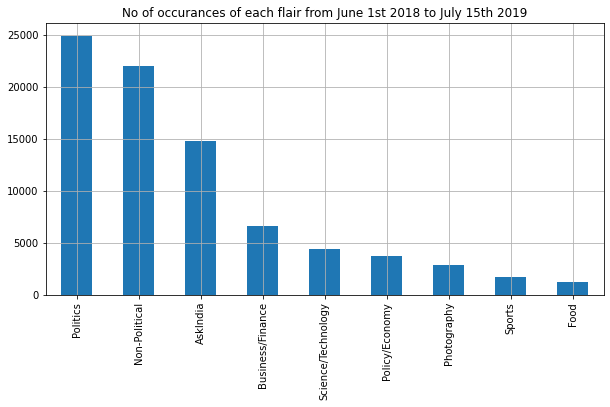

In [0]:
plt.figure(figsize=(10,5))
df.FLAIR.value_counts().plot(kind='bar', legend=False, grid=True)
plt.title("No of occurances of each flair from June 1st 2018 to July 15th 2019")

allowed_tags = ['AskIndia','Non-Political','Politics','Policy/Economy','Sports','Food','Science/Technology','Business/Finance','Photography']

for i in allowed_tags:
    print(i, " = " ,int(df.FLAIR.str.count(i).sum()))

df.info()




In [0]:
# dividing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.TITLE, df.FLAIR, test_size=0.25, random_state = 1)

In [0]:
# timepass

import pandas as pd 
  
data = [["jai narendra modi, he is a man in politics who can change th efuture of our nation..."]] 
  
# Create the pandas DataFrame 
faltu = pd.DataFrame(data, columns = ['TITLE']) 
  
# print dataframe. 
faltu

,TITLE
0,"jai narendra modi, he is a man in politics who..."


accuracy 0.607222491517208
                    precision    recall  f1-score   support

          AskIndia       0.55      0.73      0.63      3748
  Business/Finance       0.64      0.62      0.63      1665
              Food       0.76      0.30      0.43       312
     Non-Political       0.63      0.39      0.48      5569
       Photography       0.76      0.44      0.56       712
    Policy/Economy       0.60      0.16      0.25       894
          Politics       0.60      0.89      0.72      6181
Science/Technology       0.67      0.27      0.38      1095
            Sports       0.79      0.55      0.65       454

          accuracy                           0.61     20630
         macro avg       0.67      0.48      0.53     20630
      weighted avg       0.62      0.61      0.58     20630



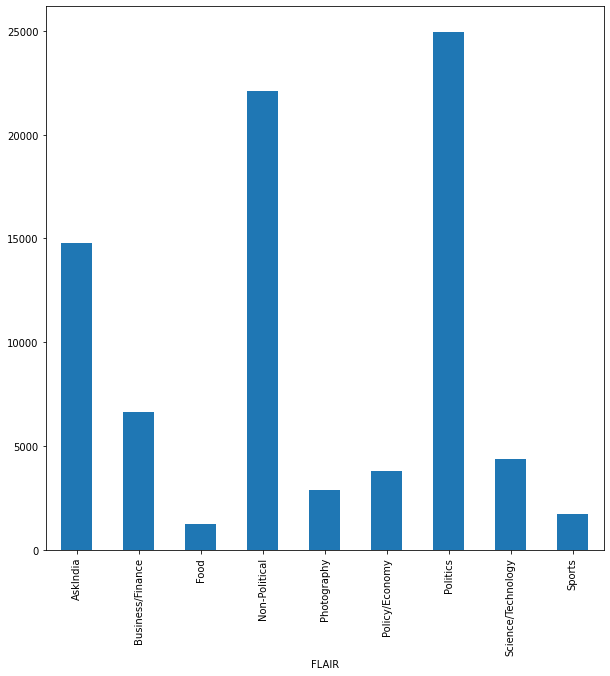

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


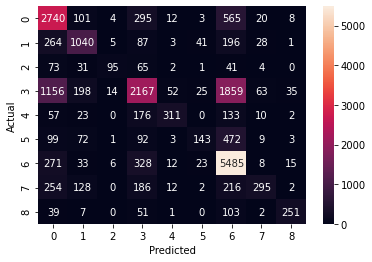

In [0]:
# linear svm

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sgd = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=1, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))


import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(8,6))
df.groupby('FLAIR').TITLE.count().plot.bar(ylim=0)
plt.show()


import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [0]:
# saving model
import pickle

pickle.dump(sgd, open('linear_svm.sav','wb'))

In [0]:
# loading model
import pickle

loaded_model = pickle.load(open('linear_svm.sav','rb'))
print(loaded_model.predict(faltu))

['AskIndia']


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.633979641299079
                    precision    recall  f1-score   support

          AskIndia       0.65      0.61      0.63      3748
  Business/Finance       0.74      0.61      0.67      1665
              Food       0.77      0.22      0.35       312
     Non-Political       0.52      0.66      0.58      5569
       Photography       0.84      0.40      0.55       712
    Policy/Economy       0.60      0.24      0.34       894
          Politics       0.70      0.80      0.75      6181
Science/Technology       0.66      0.29      0.41      1095
            Sports       0.88      0.42      0.57       454

          accuracy                           0.63     20630
         macro avg       0.71      0.48      0.54     20630
      weighted avg       0.65      0.63      0.62     20630



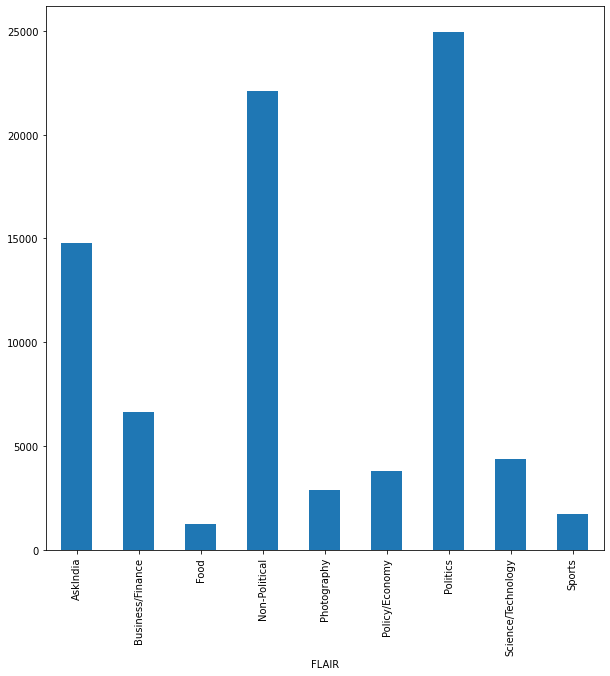

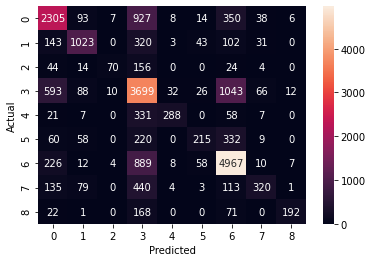

In [0]:
# logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sgd = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver = 'lbfgs')),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))


import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(8,6))
df.groupby('FLAIR').TITLE.count().plot.bar(ylim=0)
plt.show()


import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [0]:
# saving model
import pickle

pickle.dump(sgd, open('lr.sav','wb'))

accuracy 0.5660203587009209
                    precision    recall  f1-score   support

          AskIndia       0.54      0.68      0.60      3748
  Business/Finance       0.73      0.51      0.60      1665
              Food       0.65      0.20      0.30       312
     Non-Political       0.45      0.61      0.52      5569
       Photography       0.72      0.30      0.42       712
    Policy/Economy       0.56      0.17      0.26       894
          Politics       0.68      0.67      0.67      6181
Science/Technology       0.61      0.16      0.26      1095
            Sports       0.87      0.31      0.46       454

          accuracy                           0.57     20630
         macro avg       0.65      0.40      0.46     20630
      weighted avg       0.59      0.57      0.55     20630



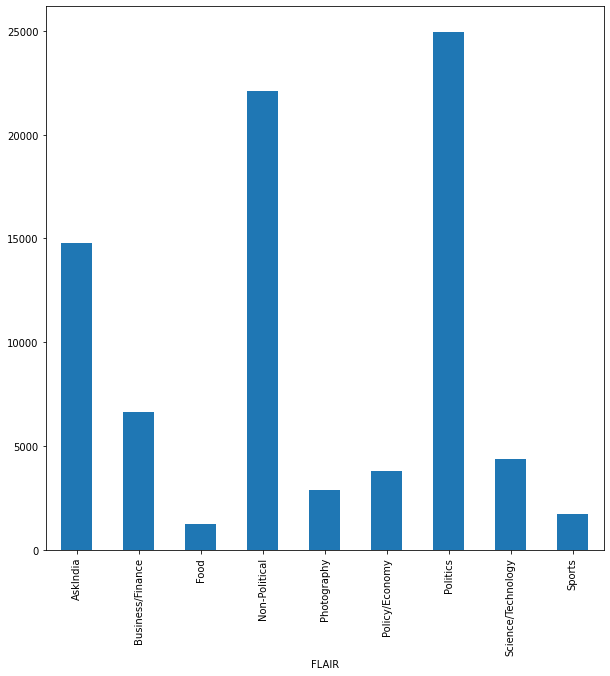

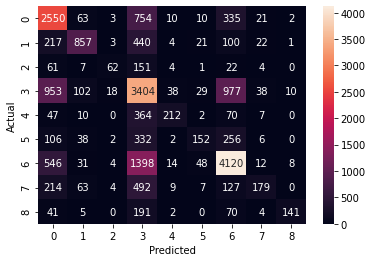

In [0]:
# Random Forest classifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=10)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))


import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(8,6))
df.groupby('FLAIR').TITLE.count().plot.bar(ylim=0)
plt.show()


import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


accuracy 0.5661657779932138
                    precision    recall  f1-score   support

          AskIndia       0.57      0.64      0.60      3748
  Business/Finance       0.88      0.41      0.56      1665
              Food       0.90      0.03      0.06       312
     Non-Political       0.48      0.55      0.51      5569
       Photography       1.00      0.06      0.12       712
    Policy/Economy       0.67      0.00      0.01       894
          Politics       0.59      0.88      0.71      6181
Science/Technology       0.95      0.06      0.11      1095
            Sports       1.00      0.04      0.07       454

          accuracy                           0.57     20630
         macro avg       0.78      0.30      0.30     20630
      weighted avg       0.63      0.57      0.52     20630



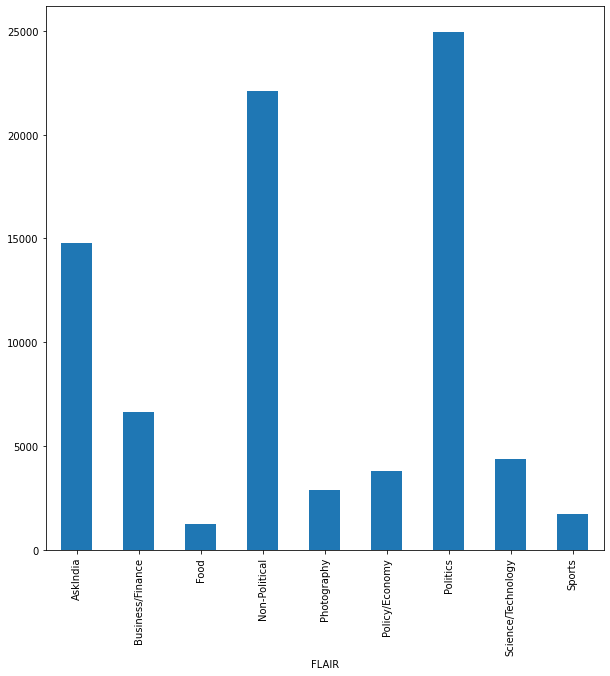

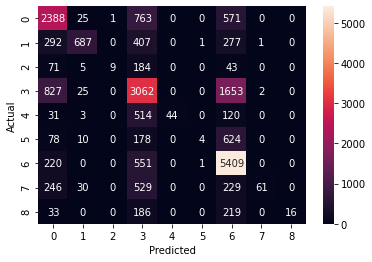

In [0]:
# NAIVE- BAYES

from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sgd = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))


import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(8,6))
df.groupby('FLAIR').TITLE.count().plot.bar(ylim=0)
plt.show()


import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [0]:
from sklearn.model_selection import train_test_split

#df2 = df[df.FLAIR != "Politics"]
#df2 = df2[df.FLAIR != "Non-Political"]
#df2 = df2[df.FLAIR != "AskIndia"]
X_train, X_test, y_train, y_test = train_test_split(df.TITLE, df.FLAIR, test_size=0.25, random_state = 1)

In [0]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
# separate minority and majority classes
to_reduce = X[X.FLAIR=='Non-Political']
minimum = X[X.FLAIR!='Non-Political']

# downsample majority
downsampled = resample(to_reduce,
                                replace = False, # sample without replacement
                                n_samples = 3000, # match minority n
                                random_state = 27) # reproducible results
#print(downsampled)
# combine minority and downsampled majority
downsampled = pd.concat([downsampled, minimum])
downsampled.FLAIR.value_counts()

Politics              18754
AskIndia              11056
Business/Finance       4976
Science/Technology     3287
Non-Political          3000
Policy/Economy         2892
Photography            2185
Sports                 1296
Food                    917
Name: FLAIR, dtype: int64

In [0]:
from sklearn.utils import resample

# separate minority and majority classes
to_reduce = downsampled[downsampled.FLAIR=='Politics']
minimum = downsampled[downsampled.FLAIR!='Politics']

# downsample majority
downsampled = resample(to_reduce,
                                replace = False, # sample without replacement
                                n_samples = 2500, # match minority n
                                random_state = 27) # reproducible results
#print(downsampled)
# combine minority and downsampled majority
downsampled = pd.concat([downsampled, minimum])
downsampled.FLAIR.value_counts()

AskIndia              11056
Business/Finance       4976
Science/Technology     3287
Non-Political          3000
Policy/Economy         2892
Politics               2500
Photography            2185
Sports                 1296
Food                    917
Name: FLAIR, dtype: int64

In [0]:
from sklearn.utils import resample

# separate minority and majority classes
to_reduce = downsampled[downsampled.FLAIR=='AskIndia']
minimum = downsampled[downsampled.FLAIR!='AskIndia']

# downsample majority
downsampled = resample(to_reduce,
                                replace = False, # sample without replacement
                                n_samples = 2000, # match minority n
                                random_state = 27) # reproducible results
#print(downsampled)
# combine minority and downsampled majority
downsampled = pd.concat([downsampled, minimum])
downsampled.FLAIR.value_counts()

Business/Finance      4976
Science/Technology    3287
Non-Political         3000
Policy/Economy        2892
Politics              2500
Photography           2185
AskIndia              2000
Sports                1296
Food                   917
Name: FLAIR, dtype: int64

In [0]:
from sklearn.utils import resample

# separate minority and majority classes
to_reduce = downsampled[downsampled.FLAIR=='Business/Finance']
minimum = downsampled[downsampled.FLAIR!='Business/Finance']

# downsample majority
downsampled = resample(to_reduce,
                                replace = False, # sample without replacement
                                n_samples = 2000, # match minority n
                                random_state = 27) # reproducible results
#print(downsampled)
# combine minority and downsampled majority
downsampled = pd.concat([downsampled, minimum])
downsampled.FLAIR.value_counts()

Science/Technology    3287
Non-Political         3000
Policy/Economy        2892
Politics              2500
Photography           2185
Business/Finance      2000
AskIndia              2000
Sports                1296
Food                   917
Name: FLAIR, dtype: int64

In [0]:
from sklearn.utils import resample

# separate minority and majority classes
to_reduce = downsampled[downsampled.FLAIR=='Science/Technology']
minimum = downsampled[downsampled.FLAIR!='Science/Technology']

# downsample majority
downsampled = resample(to_reduce,
                                replace = False, # sample without replacement
                                n_samples = 2000, # match minority n
                                random_state = 27) # reproducible results
#print(downsampled)
# combine minority and downsampled majority
downsampled = pd.concat([downsampled, minimum])
downsampled.FLAIR.value_counts()

Non-Political         3000
Policy/Economy        2892
Politics              2500
Photography           2185
Business/Finance      2000
Science/Technology    2000
AskIndia              2000
Sports                1296
Food                   917
Name: FLAIR, dtype: int64

In [0]:
from sklearn.utils import resample

# separate minority and majority classes
to_reduce = downsampled[downsampled.FLAIR=='Policy/Economy']
minimum = downsampled[downsampled.FLAIR!='Policy/Economy']

# downsample majority
downsampled = resample(to_reduce,
                                replace = False, # sample without replacement
                                n_samples = 2000, # match minority n
                                random_state = 27) # reproducible results
#print(downsampled)
# combine minority and downsampled majority
downsampled = pd.concat([downsampled, minimum])
print(downsampled.FLAIR.value_counts())





Non-Political         3000
Politics              2500
Photography           2185
Policy/Economy        2000
Business/Finance      2000
Science/Technology    2000
AskIndia              2000
Sports                1296
Food                   917
Name: FLAIR, dtype: int64


In [0]:
# performing ML on downsampled

accuracy 0.5424624333494911
                    precision    recall  f1-score   support

          AskIndia       0.61      0.60      0.60      3748
  Business/Finance       0.53      0.65      0.58      1665
              Food       0.35      0.62      0.45       312
     Non-Political       0.60      0.26      0.37      5569
       Photography       0.25      0.80      0.38       712
    Policy/Economy       0.31      0.54      0.40       894
          Politics       0.75      0.69      0.72      6181
Science/Technology       0.38      0.47      0.42      1095
            Sports       0.35      0.79      0.48       454

          accuracy                           0.54     20630
         macro avg       0.46      0.60      0.49     20630
      weighted avg       0.60      0.54      0.54     20630



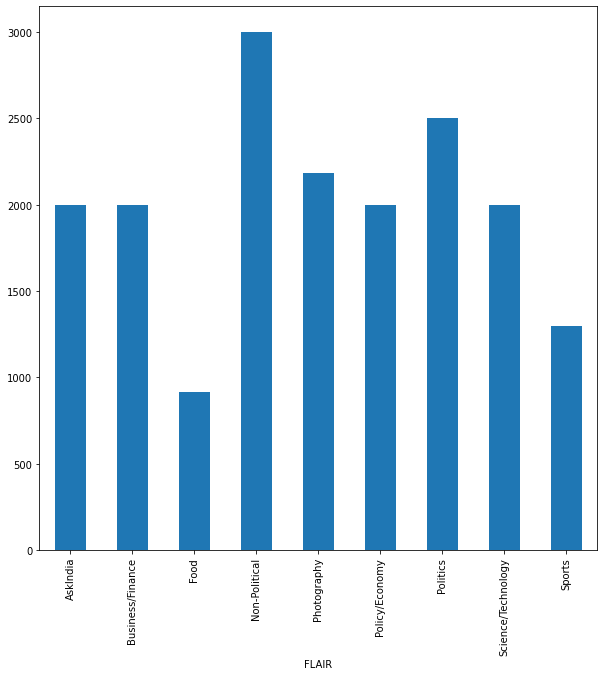

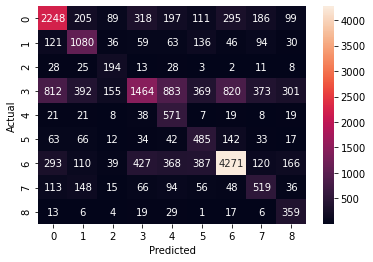

In [0]:
# linear svm
y_train = downsampled.FLAIR
X_train = downsampled.TITLE



from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))


import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(8,6))
downsampled.groupby('FLAIR').TITLE.count().plot.bar(ylim=0)
plt.show()


import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


accuracy 0.4596703829374697
                    precision    recall  f1-score   support

          AskIndia       0.51      0.59      0.55      3748
  Business/Finance       0.46      0.55      0.50      1665
              Food       0.27      0.34      0.30       312
     Non-Political       0.41      0.41      0.41      5569
       Photography       0.26      0.58      0.35       712
    Policy/Economy       0.22      0.35      0.27       894
          Politics       0.74      0.44      0.55      6181
Science/Technology       0.26      0.28      0.27      1095
            Sports       0.48      0.50      0.49       454

          accuracy                           0.46     20630
         macro avg       0.40      0.45      0.41     20630
      weighted avg       0.51      0.46      0.47     20630



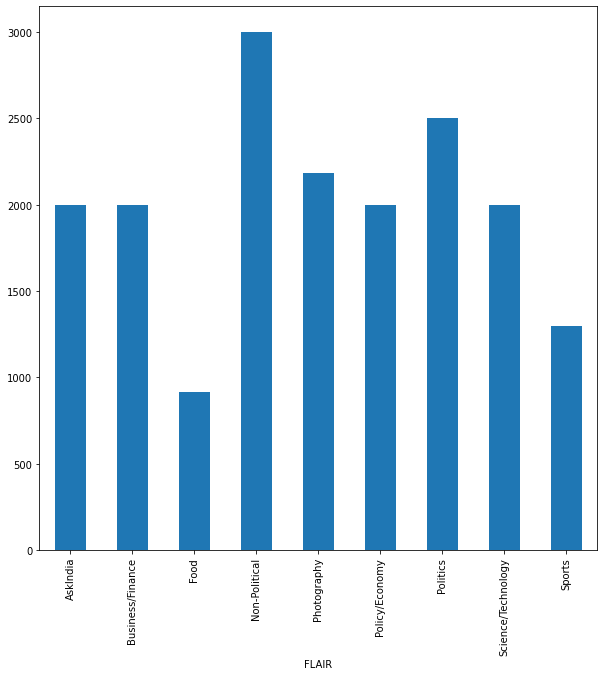

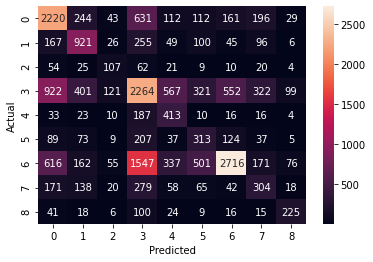

In [0]:
# Random Forest classifier
y_train = downsampled.FLAIR
X_train = downsampled.TITLE



from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=10)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))


import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(8,6))
downsampled.groupby('FLAIR').TITLE.count().plot.bar(ylim=0)
plt.show()


import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


accuracy 0.5904507998061076
                    precision    recall  f1-score   support

          AskIndia       0.55      0.68      0.60      3748
  Business/Finance       0.75      0.53      0.62      1665
              Food       0.76      0.17      0.27       312
     Non-Political       0.49      0.62      0.54      5569
       Photography       0.57      0.60      0.58       712
    Policy/Economy       0.37      0.46      0.41       894
          Politics       0.79      0.62      0.69      6181
Science/Technology       0.59      0.34      0.44      1095
            Sports       0.83      0.48      0.61       454

          accuracy                           0.59     20630
         macro avg       0.63      0.50      0.53     20630
      weighted avg       0.62      0.59      0.59     20630



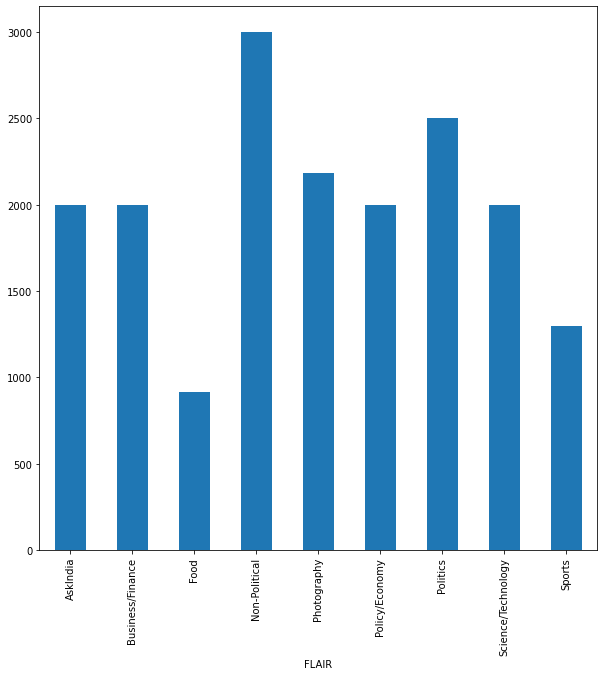

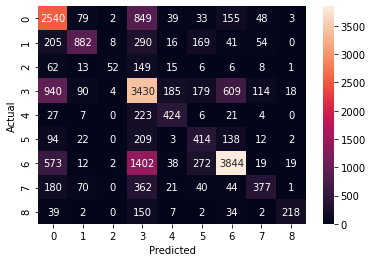

In [0]:
# NAIVE- BAYES
y_train = downsampled.FLAIR
X_train = downsampled.TITLE



from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))


import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(8,6))
downsampled.groupby('FLAIR').TITLE.count().plot.bar(ylim=0)
plt.show()


import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [0]:
# timepass

import pandas as pd 
  
data = [["feeling excited for todays match"]] 
  
# Create the pandas DataFrame 
faltu = pd.DataFrame(data, columns = ['TITLE']) 
  
# print dataframe. 
faltu


print(sgd.predict(faltu))

['AskIndia']


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5597014925373134
                    precision    recall  f1-score   support

          AskIndia       0.64      0.55      0.59      4038
  Business/Finance       0.63      0.63      0.63      1820
              Food       0.56      0.46      0.51       320
     Non-Political       0.54      0.49      0.52      7085
       Photography       0.38      0.65      0.48       653
    Policy/Economy       0.30      0.53      0.38       903
          Politics       0.78      0.64      0.70      6307
       Reddiquette       0.17      0.32      0.22       775
Science/Technology       0.40      0.54      0.46      1214
            Sports       0.60      0.72      0.66       603

          accuracy                           0.56     23718
         macro avg       0.50      0.55      0.51     23718
      weighted avg       0.60      0.56      0.57     23718



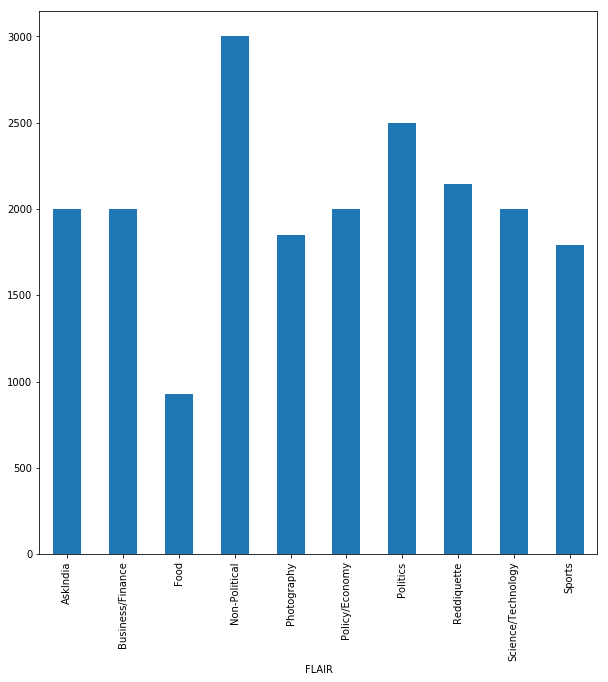

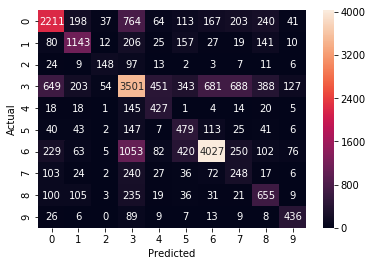

In [0]:
# logistic regression
y_train = downsampled.FLAIR
X_train = downsampled.TITLE



from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sgd = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver = 'lbfgs')),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))


import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(8,6))
downsampled.groupby('FLAIR').TITLE.count().plot.bar(ylim=0)
plt.show()


import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [0]:
# saving model
import pickle

pickle.dump(sgd, open('lr_balanced.sav','wb'))